# Compare Models

Ascertain difference between prefit-Y model and model that uses direct observations

# Inputs

In [1]:
%env THEANO_FLAGS='base_compiledir=/mnt/research_serializations/Compare-Prefit-Ys-with-Direct-Observations'

env: THEANO_FLAGS='base_compiledir=/mnt/research_serializations/Compare-Prefit-Ys-with-Direct-Observations'


In [2]:
import rnaseq_lib3 as r
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import numpy as np
import time
import os
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

In [4]:
out_dir = '/mnt/research_serializations/Compare-Prefit-Ys-with-Direct-Observations'

# Define Direct Observation Model

In [12]:
def run_DO_model(sample, df, training_genes, class_col='tissue'):
    """Run direct observation bayesian model"""
    # Create categorical index
    idx = df[class_col].astype('category').cat.codes
    classes = df[class_col].unique()

    # Define model and sample
    with pm.Model() as model:
        a = pm.Normal('a', mu=0, sd=10)
        eps = pm.InverseGamma('eps', 2.1, 1)
        
        # Beta
        b = [1] if len(classes) == 1 else pm.Dirichlet('b', a=np.ones(len(classes)))
        #mu_b = pm.Normal('mu_b', mu=0, sd=10)
        #sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
        #b = pm.LogitNormal('b', mu=mu_b, sd=sigma_b, shape=len(classes))


        # Linear model
        for gene in training_genes:
            mu = a + b[idx] * df[gene]
            pm.Laplace(gene, mu=mu, b=eps, observed=sample[gene])

        trace = pm.sample(tune=1000)
    return model, trace

In [ ]:
def ppc_from_coefs(trace, genes, background_df, class_col, num_samples=None):
    """Draws posterior using the linear model coefficients"""
    num_samples = 1_000_000 // len(background_df) if num_samples is None else num_samples

    # Categorical code mapping
    codes = {cat: i for i, cat in enumerate(background_df[class_col].unique())}
    code_vec = [codes[x] for x in background_df[class_col]]

    # Calculate posterior from linear model
    df_len = len(background_df)
    zs = {gene: np.zeros(df_len * num_samples) for gene in genes}
    sub = background_df[genes]
    for i in tqdm(range(num_samples), total=num_samples):
        z = trace['a'][i] + sub.mul([trace['b'][i, x] for x in code_vec], axis=0)
        for j, gene in enumerate(z.columns):
            zs[gene][df_len * i: df_len * (i+1)] = np.random.laplace(loc=z[gene], scale=trace['eps'].mean())
    return zs


def posterior_predictive_pvals(sample: pd.Series, ppc: Dict[str, np.array]):
    pvals = {}
    for gene in tqdm(ppc):
        z_true = sample[gene]
        z = ppc[gene]
        pvals[gene] = _ppp_one_gene(z_true, z)
    return pvals

# Runs

In [8]:
sample = tumor.loc['TCGA-OR-A5JW-01']

ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]
training_genes = r.outlier.select_k_best_genes(training_group, genes, 'tissue', 50)
training_genes = list(set(training_genes + list(np.random.choice(drug_genes, 50))))

## DO Model

In [13]:
m0, t0 = run_DO_model(sample, training_group, training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, eps, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [12:44<00:00,  5.16draws/s]  


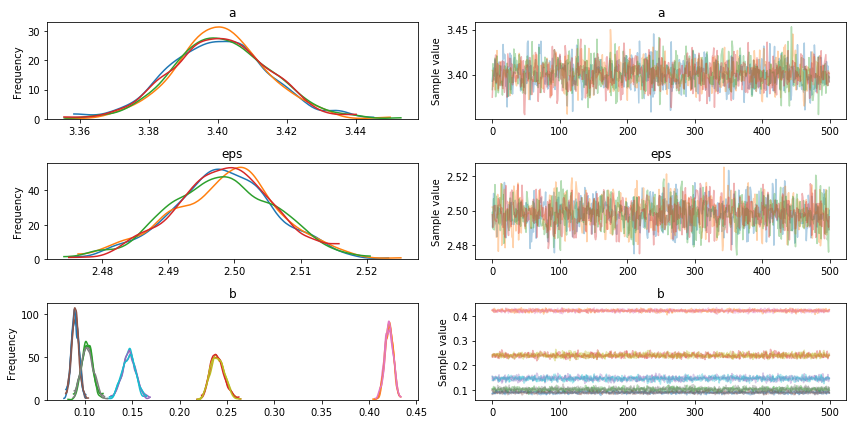

In [14]:
pm.traceplot(t0);

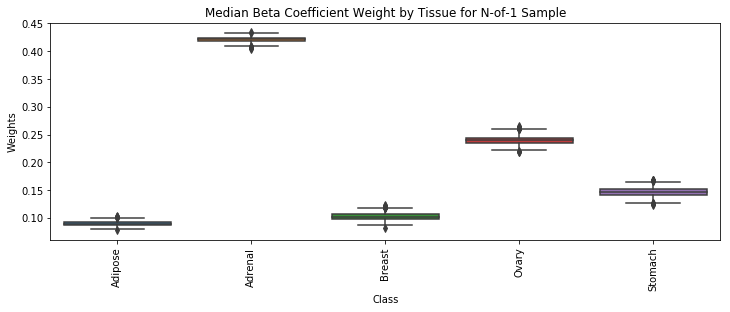

In [15]:
r.outlier.plot_weights(training_group.tissue.unique(), t0)